### TensorFlow 2.0 설치
[런타임] -> [런타임 유형변경]에서 하드웨어 가속기를 꼭 GPU로 설정!

In [1]:
## TF 2.0 GPU 설치
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 47kB/s 
     |████████████████████████████████| 3.8MB 18.0MB/s 
     |████████████████████████████████| 450kB 42.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


### Google Drive 연동

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Oxford-IIIT Pet Dataset 준비

In [3]:
cd '/content/drive/My Drive/new_drug_adv_tf/'

/content/drive/My Drive/practice


In [13]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/drive/My Drive/practice/oxford_pet.zip
811MB [00:08, 91.4MB/s]


'oxford_pet.zip'

In [23]:
## oxford_pet.zip이 보이는지 확인
!ls -l

total 1044766
-rw------- 1 root root      3667 Oct 18 00:01  0_0.GoogleDriveMount_GitClone.ipynb
-rw------- 1 root root      4697 Oct 11 17:49  0_1.GoogleDriveMount_GitClone.ipynb
-rw------- 1 root root     32822 Aug 30 23:22  10_7.text_generation.ipynb
-rw------- 1 root root     27342 Aug 30 23:23  11_1.style_transfer.ipynb
-rw------- 1 root root     25573 Aug 30 23:20  11_1.style_transfer_mod.ipynb
-rw------- 1 root root     24167 Aug 31 00:10  11_2.dcgan.ipynb
-rw------- 1 root root    976317 Aug 31 02:00  11_3.pix2pix.ipynb
-rw------- 1 root root     42819 Oct 11 16:45  1_1.python_numpy_basic.ipynb
-rw------- 1 root root     21334 Oct 11 16:47  1_2.TensorFlow_Basics_1.x.ipynb
-rw------- 1 root root     36066 Oct 11 16:51  1_2.TensorFlow_Basics_2.0.ipynb
-rw------- 1 root root    375315 Oct 23 00:00  3_2.Class_Activation_Map.ipynb
-rw------- 1 root root    658571 Jul 19 23:04  6_0.prepare_dataset.ipynb
-rw------- 1 root root    170330 Apr  5  2019  boat.jpg
drwx------ 2 root root   

In [16]:
## 압축풀기
!unzip oxford_pet.zip -d oxford_pet

Archive:  oxford_pet.zip
  inflating: oxford_pet/annotations/._trimaps  
  inflating: oxford_pet/annotations/list.txt  
  inflating: oxford_pet/annotations/README  
  inflating: oxford_pet/annotations/test.txt  
  inflating: oxford_pet/annotations/trainval.txt  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_1.png  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_10.png  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_100.png  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_101.png  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_102.png  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_103.png  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_104.png  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_105.png  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_106.png  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_107.png  
  inflating: oxford_pet/annotations/trimaps/Abyssinian_108.png  
  inflating: oxford_pet/a

# Localization을 위한 tfrecord 만들기

In [4]:
## library import
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import shutil
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.0.0


In [5]:
!pwd

/content/drive/My Drive/practice


In [0]:
## directory 정보
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
anno_dir = os.path.join(data_dir, 'annotations', 'xmls')

In [29]:
## localization을 위한 annotation이 되어 있는 file의 수 확인
anno_files = [fname for fname in os.listdir(anno_dir) if os.path.splitext(fname)[-1] == '.xml']
len(anno_files)

3686

In [30]:
## image file의 수 확인
img_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
len(img_files)

7390

In [0]:
## 개와 고양이 directory로 생성
dog_dir = os.path.join(data_dir, 'dogs')
cat_dir = os.path.join(data_dir, 'cats')
os.makedirs(dog_dir, exist_ok=True)
os.makedirs(cat_dir, exist_ok=True)

In [0]:
## segmentation을 위한 annotation이 되어 있는 directory 경로 설정
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [0]:
'''localization을 위한 annotation이 되어 있는 directory에서 file을 하나씩 읽어서, 
관련된 image file을 찾은 뒤, 개 image는 dogs 디렉토리에, 고양이 image는 cats 디렉토리에 복사
이 때 file 이름이 대문자로 시작하면 고양이, 소문자로 시작하면 개의 image 임을 이용함
또 이 image들이 segmentaion을 위한 annotation도 되어 있는지 확인함'''

cat_cnt = 0
dog_cnt = 0
for anno_file in anno_files:
    ## annotation 파일이름에서 확장자 뺀 앞부분만 추출
    fname = os.path.splitext(anno_file)[0]
    ## segmentation annotation은 png file format
    sname = fname + '.png'
    ## image file은 jpg format
    fname = fname + '.jpg'
    fpath = os.path.join(image_dir, fname)
    ## file 이름의 첫글자가 소문자인지 확인
    if fname[0].islower():
        dog_cnt += 1
        cpath = os.path.join(dog_dir, fname)
    else:
        cat_cnt += 1
        cpath = os.path.join(cat_dir, fname)    
    ## segmentation annotation도 있는지 확인
    if sname not in os.listdir(seg_dir):
        print(sname)
    ## data copy
    shutil.copy(fpath, cpath)

In [34]:
print("총 복사된 image 수: {}".format(dog_cnt+cat_cnt))
print("개 image 수: {}".format(dog_cnt))
print("고양이 image 수: {}".format(cat_cnt))

총 복사된 image 수: 3686
개 image 수: 2498
고양이 image 수: 1188


In [0]:
## validation data를 나누기 위한 directory 생성
val_dir = os.path.join(data_dir, 'dogs_val')
os.makedirs(val_dir, exist_ok=True)

In [0]:
## train data와 validation data를 나누기 위한 index 생성
train_idx, val_idx = train_test_split(np.arange(dog_cnt), train_size=0.80065)

In [37]:
## train, validation data 수 확인
print("train data의 수: {}".format(train_idx.shape[0]))
print("validation data의 수: {}".format(val_idx.shape[0]))

train data의 수: 2000
validation data의 수: 498


In [38]:
## validation data를 validatino directory로 이동
dog_files = os.listdir(dog_dir)

val_cnt = 0
for idx, dog_file in enumerate(dog_files):
    fpath = os.path.join(dog_dir, dog_file)
    mpath = os.path.join(val_dir, dog_file)
    if idx in val_idx:
        shutil.move(fpath, mpath)
        val_cnt += 1
print(val_cnt)
print(dog_cnt - val_cnt)

498
2000


In [0]:
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
train_dir = os.path.join(data_dir, 'dogs')
val_dir = os.path.join(data_dir, 'dogs_val')
anno_dir = os.path.join(data_dir, 'annotations', 'xmls')

In [0]:
## tfrecord 파일 저장할 directory 생성
tfr_dir = os.path.join(cur_dir, 'dogs_tfr')
os.makedirs(tfr_dir, exist_ok=True)

In [40]:
## tfrecord 파일 경로 설정
tfr_train = 'dogs_train.tfrecord'
tfr_val = 'dogs_val.tfrecord'

tfr_train_dir = os.path.join(tfr_dir, tfr_train)
tfr_val_dir = os.path.join(tfr_dir, tfr_val)
tfr_train_dir

'/content/drive/My Drive/practice/dogs_tfr/dogs_train.tfrecord'

In [0]:
## tfrecord writer
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [0]:
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [45]:
## train data의 tfrecord file 생성
img_size = 224
fnames = os.listdir(train_dir)
n_train = 0
for fname in fnames:
    ## train data directory에서 file을 읽어서 serialize
    fpath = os.path.join(train_dir, fname)
    img = Image.open(fpath)
    img = img.resize((img_size, img_size))
    img = np.asarray(img)
    img_str = img.tobytes()
    
    '''bounding box의 정보가 있는 xml file을 열어서 좌표 정보를 parsing한 후,
    boudnign box의 중심점의 x, y 좌표와 width, height를 계산함
    이 때 0~1사이의 값이 되도록 width와 height로 나눠줌'''
    aname = os.path.splitext(fname)[0] + '.xml'
    apath = os.path.join(anno_dir, aname)
    tree = et.parse(apath)
    ## xml file parsing
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    ## x, y, w, h 계산
    xc = (xmin+xmax)/2.
    yc = (ymin+ymax)/2.
    x = xc/width
    y = yc/height
    w = (xmax-xmin)/width
    h = (ymax-ymin)/height
    
    ## tfrecord file로 write
    example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(img_str),
            'x': _float_feature(x),
            'y': _float_feature(y),
            'w': _float_feature(w),
            'h': _float_feature(h)}))
    writer_train.write(example.SerializeToString())
    n_train += 1    

print(n_train)

2000


In [46]:
## validation data의 tfrecord file 생성
img_size = 224
fnames = os.listdir(val_dir)
n_val = 0
for fname in fnames:
    ## validation data directory에서 file을 읽어서 serialize
    fpath = os.path.join(val_dir, fname)
    img = Image.open(fpath)
    img = img.resize((img_size, img_size))
    img = np.asarray(img)
    img_str = img.tobytes()
    
    '''bounding box의 정보가 있는 xml file을 열어서 좌표 정보를 parsing한 후,
    boudnign box의 중심점의 x, y 좌표와 width, height를 계산함
    이 때 0~1사이의 값이 되도록 width와 height로 나눠줌'''
    aname = os.path.splitext(fname)[0] + '.xml'
    apath = os.path.join(anno_dir, aname)
    tree = et.parse(apath)
    ## xml file parsing
    width = float(tree.find('./size/width').text)
    height = float(tree.find('./size/height').text)
    xmin = float(tree.find('./object/bndbox/xmin').text)
    ymin = float(tree.find('./object/bndbox/ymin').text)
    xmax = float(tree.find('./object/bndbox/xmax').text)
    ymax = float(tree.find('./object/bndbox/ymax').text)
    ## x, y, w, h 계산
    xc = (xmin+xmax)/2.
    yc = (ymin+ymax)/2.
    x = xc/width
    y = yc/height
    w = (xmax-xmin)/width
    h = (ymax-ymin)/height
    
    ## tfrecord file로 write
    example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(img_str),
            'x': _float_feature(x),
            'y': _float_feature(y),
            'w': _float_feature(w),
            'h': _float_feature(h)}))
    writer_val.write(example.SerializeToString())
    n_val += 1

print(n_val)

498


In [47]:
## file이 제대로 생성되었는지 확인
!ls -l 'dogs_tfr'

total 367456
-rw------- 1 root root 301260800 Oct 23 15:15 dogs_train.tfrecord
-rw------- 1 root root  75014144 Oct 23 15:15 dogs_val.tfrecord


# Localization

In [140]:
## library import
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from matplotlib.patches import Rectangle

print(tf.__version__)
print(keras.__version__)

2.0.0
2.2.4-tf


In [0]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [0]:
## hyper parameter 설정
batch_size = 20
learning_rate = 0.0001
training_epochs = 30
img_size = 224
n_train = 2000
n_val = 498

In [0]:
## tfrecord file 경로 설정
cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'dogs_tfr')

tfr_train = 'dogs_train.tfrecord'
tfr_val = 'dogs_val.tfrecord'

tfr_train_dir = os.path.join(tfr_dir, tfr_train)
tfr_val_dir = os.path.join(tfr_dir, tfr_val)

In [0]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'x': tf.io.FixedLenFeature([], tf.float32),
              'y': tf.io.FixedLenFeature([], tf.float32),
              'w': tf.io.FixedLenFeature([], tf.float32),
              'h': tf.io.FixedLenFeature([], tf.float32)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [img_size, img_size, 3])
    image = tf.cast(image, tf.float32)/255.
    #image = preprocess_input(image)
    
    x = tf.cast(parsed_features['x'], tf.float32)
    y = tf.cast(parsed_features['y'], tf.float32)
    w = tf.cast(parsed_features['w'], tf.float32)
    h = tf.cast(parsed_features['h'], tf.float32)
    gt = tf.stack([x, y, w, h], -1)
    
    return image, gt

In [0]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=8)
train_dataset = train_dataset.shuffle(buffer_size=n_train).prefetch(
    buffer_size=batch_size).batch(batch_size).repeat()
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

In [0]:
## validation datset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=8)
val_dataset = val_dataset.prefetch(buffer_size=batch_size).batch(batch_size).repeat()
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())

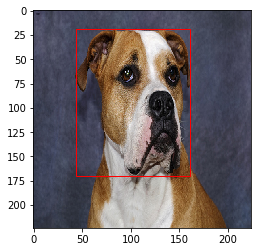

In [147]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, gt in val_dataset.take(1):
    
    '''그림을 그리기 위해서 bbox의 왼쪽 위 꼭지점 좌표를 계산하고, 
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''
    x = gt[:,0]
    y = gt[:,1]
    w = gt[:,2]
    h = gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * img_size)
    rect_y = int(ymin * img_size)
    rect_w = int(w[0].numpy() * img_size)
    rect_h = int(h[0].numpy() * img_size)
    
    ## 그림 그리기
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

In [0]:
## MobileNet V2의 pretrained model을 load
conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [149]:
## localization을 위한 network
## mobilenet v2 구조에 fully connected layer 3개를 추가하고 마지막 layer는 4개의 node로 x,y,w,h를 예측하도록 함
model = models.Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               327936    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)               

In [0]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.3,
                                                          staircase=True)
## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(optimizers.RMSprop(lr_schedule), loss='mse')

In [151]:
## Train!
steps_per_epoch = n_train//batch_size
validation_steps = n_val//batch_size
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=training_epochs,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Train for 100 steps, validate for 24 steps
Epoch 1/30
100/100 [==============================] - 43s 429ms/step - loss: 0.0543 - val_loss: 0.0319
Epoch 2/30
100/100 [==============================] - 28s 281ms/step - loss: 0.0271 - val_loss: 0.0222
Epoch 3/30
100/100 [==============================] - 28s 280ms/step - loss: 0.0147 - val_loss: 0.0169
Epoch 4/30
100/100 [==============================] - 28s 281ms/step - loss: 0.0095 - val_loss: 0.0149
Epoch 5/30
100/100 [==============================] - 28s 280ms/step - loss: 0.0071 - val_loss: 0.0122
Epoch 6/30
100/100 [==============================] - 28s 281ms/step - loss: 0.0059 - val_loss: 0.0109
Epoch 7/30
100/100 [==============================] - 28s 280ms/step - loss: 0.0051 - val_loss: 0.0091
Epoch 8/30
100/100 [==============================] - 28s 281ms/step - loss: 0.0043 - val_loss: 0.0083
Epoch 9/30
100/100 [==============================] - 28s 280ms/step - loss: 0.0041 - val_loss: 0.0073
Epoch 10/30
100/100 [=========

In [0]:
## validation set에 대해서 bounding box 예측
prediction = model.predict(val_dataset, steps=steps_per_epoch)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


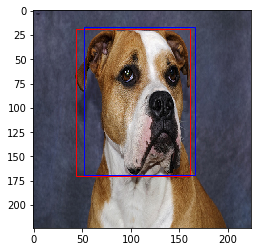

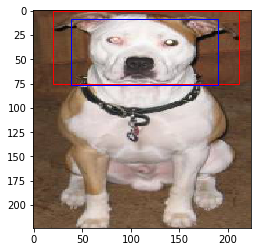

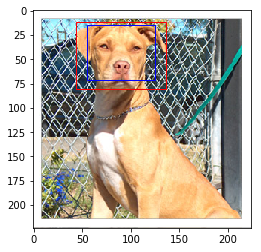

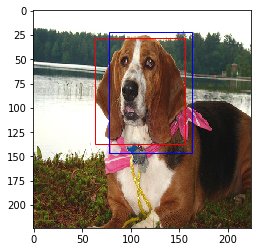

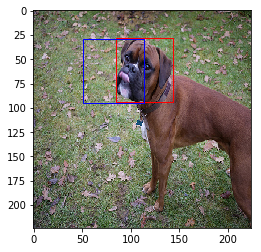

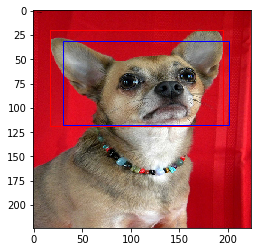

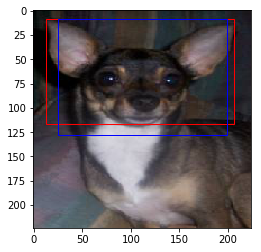

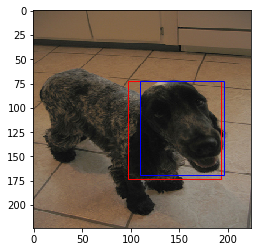

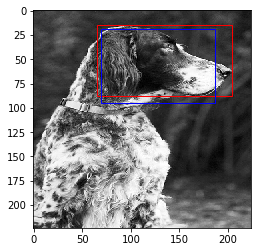

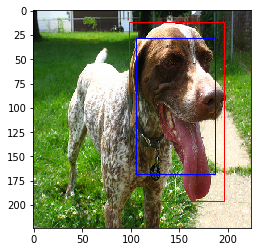

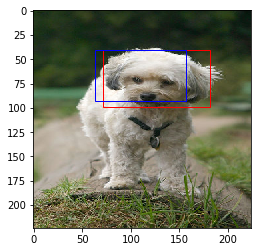

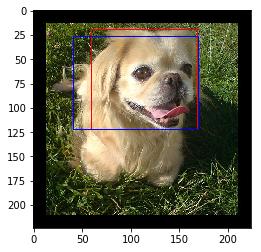

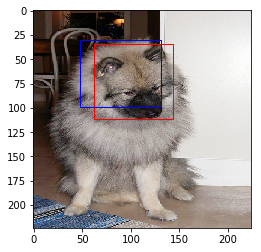

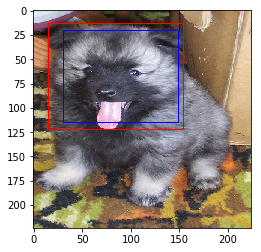

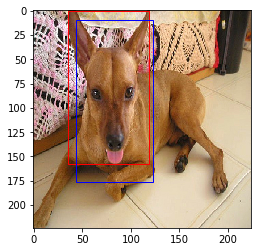

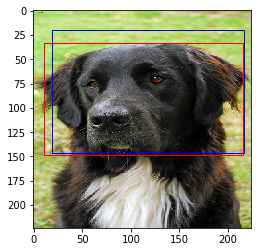

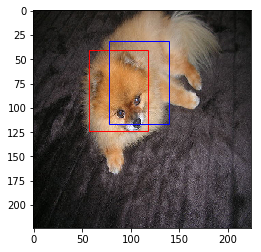

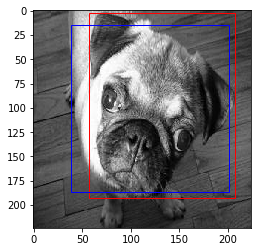

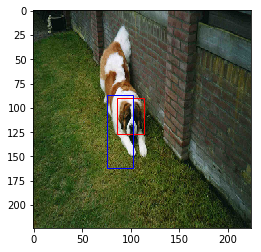

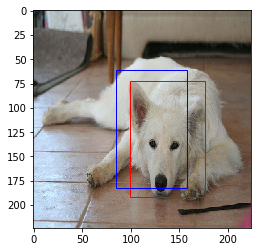

In [153]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box
idx = 0
num_imgs = 20
for val_data, val_gt in val_dataset.take(num_imgs):
    ## 정답 box 그리기
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * img_size)
    rect_y = int(ymin * img_size)
    rect_w = int(w[0].numpy() * img_size)
    rect_h = int(h[0].numpy() * img_size)
    
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    
    ## 예측 box 그리기
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx*batch_size] - pred_w[idx*batch_size]/2.
    pred_ymin = pred_y[idx*batch_size] - pred_h[idx*batch_size]/2.
    pred_rect_x = int(pred_xmin * img_size)
    pred_rect_y = int(pred_ymin * img_size)
    pred_rect_w = int(pred_w[idx*batch_size] * img_size)
    pred_rect_h = int(pred_h[idx*batch_size] * img_size)
    
    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)
    
    ## image와 bbox 함께 출력
    plt.imshow(val_data[0])
    plt.show()
    idx += 1

# Segmentation과 Colorization을 위한 tfrecord 만들기

In [18]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from PIL import Image
import shutil
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [0]:
img_size = 224

In [156]:
!pwd

/content/drive/My Drive/practice


In [0]:
## directory 정보
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
train_dir = os.path.join(data_dir, 'dogs')
val_dir = os.path.join(data_dir, 'dogs_val')
anno_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [158]:
## train, validation, annotation 파일 갯수 확인
n_train = len(os.listdir(train_dir))
n_val =len(os.listdir(val_dir))
n_anno = len(os.listdir(anno_dir))
print(n_train, n_val, n_anno)

2000 498 7390


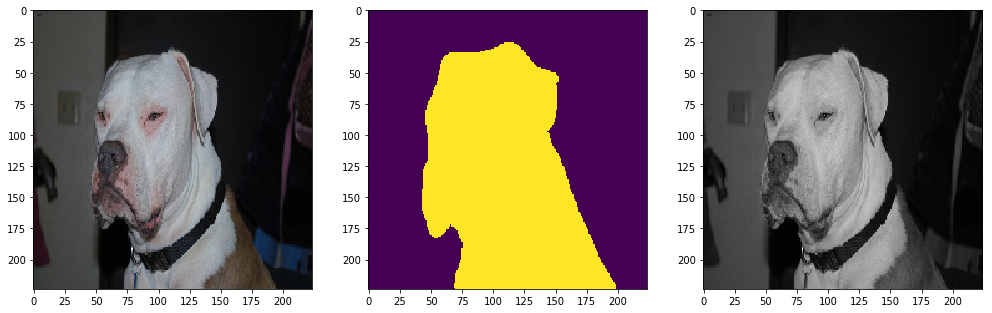

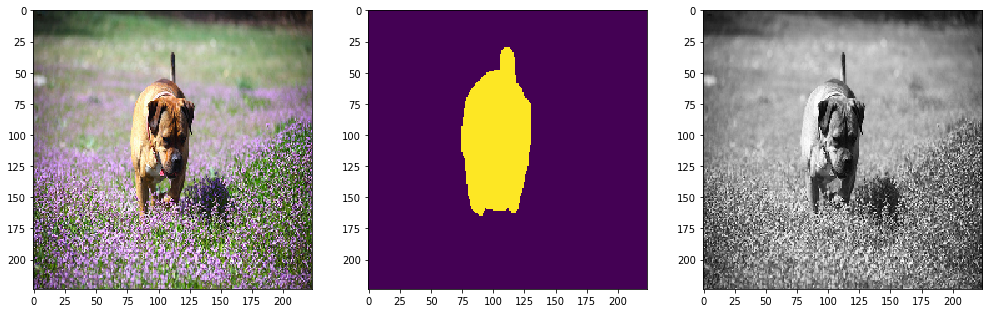

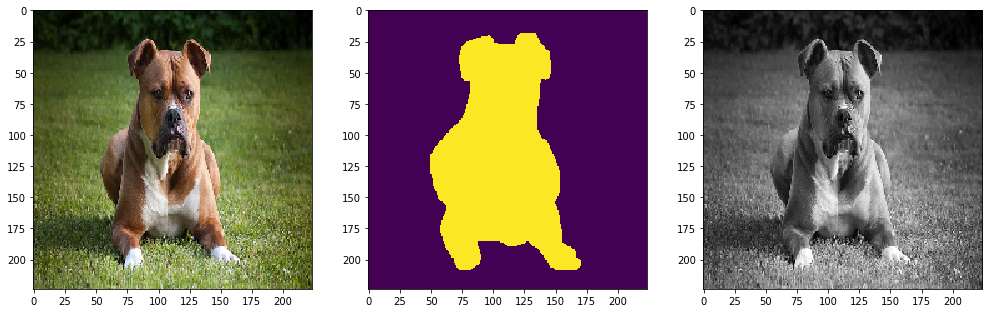

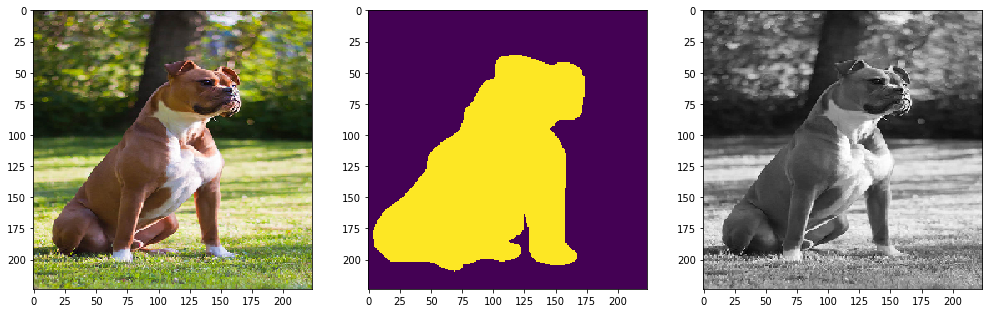

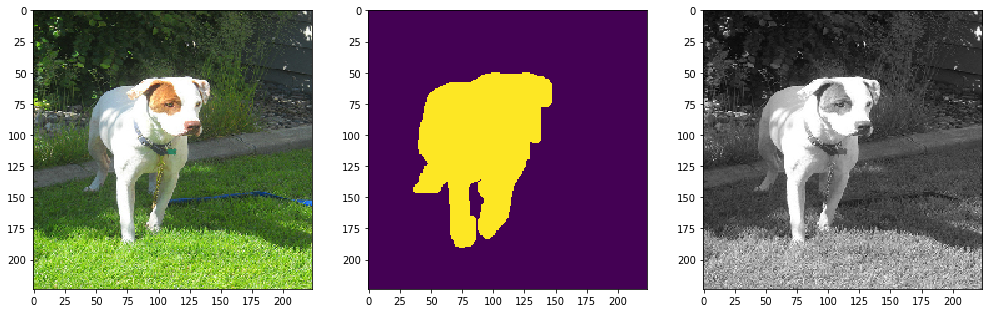

In [159]:
''' training dataset에서 num_figs만큼의 image를 가져와서
segmentation label,과 gray scale로 변환한 image를 확인'''

fnames = os.listdir(train_dir)

num_fig = 5
for i, fname in enumerate(fnames):
    ## training image
    fpath = os.path.join(train_dir, fname)    
    img = Image.open(fpath)
    img = img.resize((img_size, img_size))
    img = np.array(img)
    
    ## segmentation label
    ## 원래 label은 1: foreground, 2: background, 3: not classified 로 구성됨
    ## 이것을 0: background, 1 : foreground & not classified로 변경
    sname = os.path.splitext(fname)[0] + '.png'
    spath = os.path.join(anno_dir, sname)    
    seg = Image.open(spath)
    seg = seg.resize((img_size, img_size))
    seg = np.array(seg)
    seg[seg>2] = 1
    seg[seg==2] = 0
    
    ## gray scale로 변환
    grayimg = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
    
    plt.figure(figsize=(17, 6*num_fig))
    plt.subplot(num_fig,3,i*3+1)
    plt.imshow(img)
    plt.subplot(num_fig,3,i*3+2)    
    plt.imshow(seg)
    plt.subplot(num_fig,3,i*3+3)
    plt.imshow(grayimg, cmap='gray')    
    plt.show()
    
    if i == num_fig-1 : break

In [0]:
## tfrecord 파일 저장할 directory 생성
tfr_dir = os.path.join(cur_dir, 'dogs_tfr')
os.makedirs(tfr_dir, exist_ok=True)

In [0]:
## tfrecord 파일 경로 설정
tfr_train = 'dogs_seg_train.tfrecord'
tfr_val = 'dogs_seg_val.tfrecord'

tfr_train_dir = os.path.join(tfr_dir, tfr_train)
tfr_val_dir = os.path.join(tfr_dir, tfr_val)

In [0]:
## tfrecord writer
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [0]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [164]:
## train data의 tfrecord file 생성
fnames = os.listdir(train_dir)
n_train = 0
for fname in fnames:
    ## train data directory에서 file을 읽어서 serialize
    fpath = os.path.join(train_dir, fname)
    img = Image.open(fpath)
    img = img.resize((img_size, img_size))    
    img = np.array(img)    
    
    sname = os.path.splitext(fname)[0] + '.png'
    spath = os.path.join(anno_dir, sname)
    seg = Image.open(spath)
    seg = seg.resize((img_size, img_size))
    seg = np.array(seg)
    seg[seg>2] = 1
    seg[seg==2] = 0    
    
    grayimg = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]    
    
    img_str = img.tobytes()
    seg_str = seg.tobytes()
    grayimg_str = grayimg.tobytes()
    
    example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(img_str),
            'seg': _bytes_feature(seg_str),
            'grayimg': _bytes_feature(grayimg_str)}))
    writer_train.write(example.SerializeToString())
    n_train += 1

print(n_train)

2000


In [165]:
## validation data의 tfrecord file 생성
fnames = os.listdir(val_dir)
n_val = 0
for fname in fnames:
    ## validation data directory에서 file을 읽어서 serialize
    fpath = os.path.join(val_dir, fname)
    img = Image.open(fpath)
    img = img.resize((img_size, img_size))    
    img = np.array(img)
    img_str = img.tobytes()
    
    sname = os.path.splitext(fname)[0] + '.png'
    spath = os.path.join(anno_dir, sname)
    seg = Image.open(spath)
    seg = seg.resize((img_size, img_size))
    seg = np.array(seg)
    seg[seg>2] = 1
    seg[seg==2] = 0    
        
    grayimg = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]    
    
    img_str = img.tobytes()
    seg_str = seg.tobytes()
    grayimg_str = grayimg.tobytes()
    
    example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(img_str),
            'seg': _bytes_feature(seg_str),
            'grayimg': _bytes_feature(grayimg_str)}))
    writer_val.write(example.SerializeToString())
    n_val += 1    

print(n_val)

498


# Image Segmentation

In [0]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [0]:
## hyper parameter 설정
batch_size = 10
learning_rate = 0.0001
training_epochs = 20
img_size = 224
n_train = 2000
n_val = 498

In [0]:
## tfrecord file 경로 설정
cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'dogs_tfr')

tfr_train = 'dogs_seg_train.tfrecord'
tfr_val = 'dogs_seg_val.tfrecord'

tfr_train_dir = os.path.join(tfr_dir, tfr_train)
tfr_val_dir = os.path.join(tfr_dir, tfr_val)

In [0]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'seg': tf.io.FixedLenFeature([], tf.string),
              'grayimg': tf.io.FixedLenFeature([], tf.string)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [img_size, img_size, 3])
    image = tf.cast(image, tf.float32)/255.
    #image = preprocess_input(image)
    
    seg = tf.io.decode_raw(parsed_features['seg'], tf.uint8)
    seg = tf.reshape(seg, [img_size, img_size, -1])
    seg = tf.cast(seg, tf.float32)
    
    grayimg = tf.io.decode_raw(parsed_features['grayimg'], tf.float64)    
    grayimg = tf.reshape(grayimg, [img_size, img_size])
    grayimg = tf.stack([grayimg, grayimg, grayimg], -1)
    grayimg = tf.cast(grayimg, tf.float32)/255.
    #print(grayimg.shape)
    
    return image, seg

In [0]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=8)
train_dataset = train_dataset.prefetch(buffer_size=batch_size).batch(batch_size).shuffle(n_train).repeat()
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

In [0]:
## validation datset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=8)
val_dataset = val_dataset.prefetch(buffer_size=batch_size).batch(batch_size).repeat()
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())

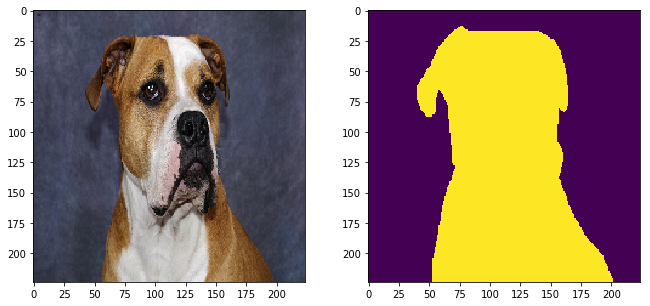

In [15]:
## train dataset에서 1개의 image와 segmentation label을 읽어서 확인
for image, seg in val_dataset.take(1):
    plt.figure(figsize=(11, 5))
    plt.subplot(1,2,1)
    plt.imshow(image[0])
    plt.subplot(1,2,2)
    plt.imshow(seg[0,:,:,0], vmin=0, vmax=1) 
    plt.show()

In [0]:
## U-Net
def create_model():
    inputs = Input(shape=(img_size, img_size, 3))
    
    conv1_1 = Conv2D(64, 3, 1, 'SAME', activation='relu')(inputs)
    conv1_2 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)
    
    conv2_1 = Conv2D(128, 3, 1, 'SAME', activation='relu')(pool1_3)
    conv2_2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)
    
    conv3_1 = Conv2D(256, 3, 1, 'SAME', activation='relu')(pool2_3)
    conv3_2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)
    
    conv4_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool3_4)
    conv4_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)
    
    conv5_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool4_4)
    conv5_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_2)
    pool5_4 = MaxPooling2D()(conv5_3)
    
    upconv6 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(pool5_4)
    concat6 = Concatenate()([conv5_3, upconv6])
    conv6 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat6)
                              
    upconv7 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(conv6)
    concat7 = Concatenate()([conv4_3, upconv7])
    conv7 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat7)
    
    upconv8 = Conv2DTranspose(256, 5, 2, 'SAME', activation='relu')(conv7)
    concat8 = Concatenate()([conv3_3, upconv8])
    conv8 = Conv2D(256, 3, 1, 'SAME', activation='relu')(concat8)
    
    upconv9 = Conv2DTranspose(128, 5, 2, 'SAME', activation='relu')(conv8)
    concat9 = Concatenate()([conv2_2, upconv9])
    conv9 = Conv2D(128, 3, 1, 'SAME', activation='relu')(concat9)
    
    upconv10 = Conv2DTranspose(64, 5, 2, 'SAME', activation='relu')(conv9)
    concat10 = Concatenate()([conv1_2, upconv10])
    conv10 = Conv2D(64, 3, 1, 'SAME', activation='relu')(concat10)
    
    conv11 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv10)
    
    conv12 = Conv2D(2, 1, 1, 'SAME', activation='softmax')(conv11)
    
    return keras.Model(inputs=inputs, outputs=conv12)   

In [20]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_21[0][0]                  
______________________________________________________________________________________________

In [0]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
model.compile(optimizers.Adam(lr_schedule), loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [22]:
## Train!
steps_per_epoch = n_train//batch_size
validation_steps = n_val//batch_size
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=training_epochs,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Train for 200 steps, validate for 49 steps
Epoch 1/20
200/200 [==============================] - 294s 1s/step - loss: 0.6262 - sparse_categorical_accuracy: 0.6500 - val_loss: 0.4610 - val_sparse_categorical_accuracy: 0.7908
Epoch 2/20
200/200 [==============================] - 262s 1s/step - loss: 0.4680 - sparse_categorical_accuracy: 0.7861 - val_loss: 0.4238 - val_sparse_categorical_accuracy: 0.8102
Epoch 3/20
200/200 [==============================] - 262s 1s/step - loss: 0.4129 - sparse_categorical_accuracy: 0.8164 - val_loss: 0.3629 - val_sparse_categorical_accuracy: 0.8469
Epoch 4/20
200/200 [==============================] - 263s 1s/step - loss: 0.3694 - sparse_categorical_accuracy: 0.8408 - val_loss: 0.3473 - val_sparse_categorical_accuracy: 0.8504
Epoch 5/20
200/200 [==============================] - 263s 1s/step - loss: 0.3358 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.3407 - val_sparse_categorical_accuracy: 0.8535
Epoch 6/20
200/200 [==============================] 

In [0]:
## validation data에 대한 예측값 생성
prediction = model.predict(val_dataset, steps=validation_steps)

In [0]:
pred = np.zeros_like(prediction)

In [0]:
## 0.5이상은 1로 나머지는 0으로 변환
thr = 0.5
pred[prediction>=thr] = 1
pred[prediction<thr] = 0

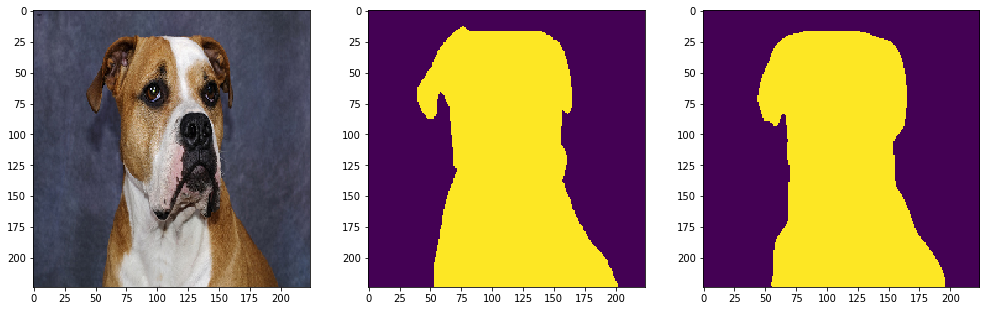

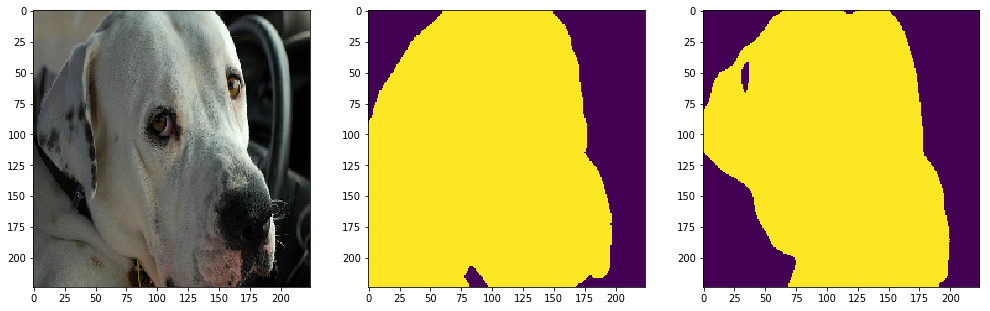

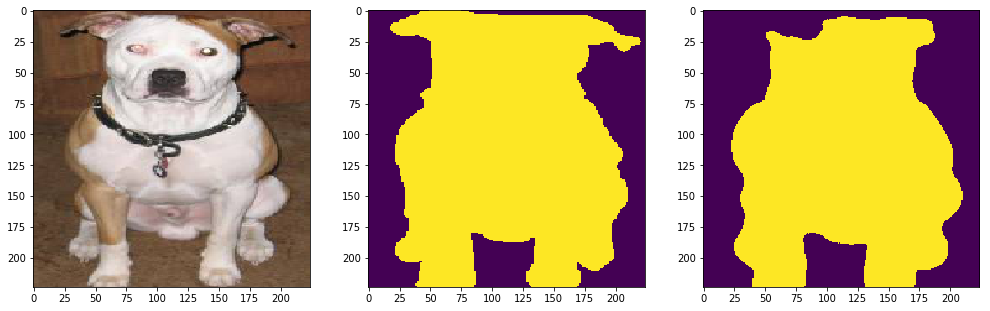

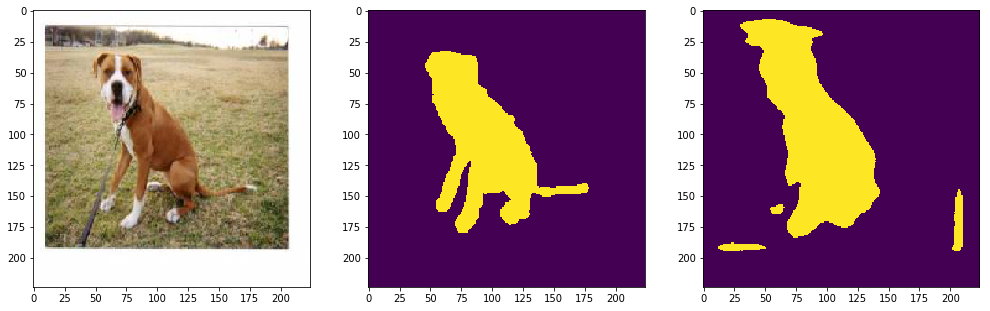

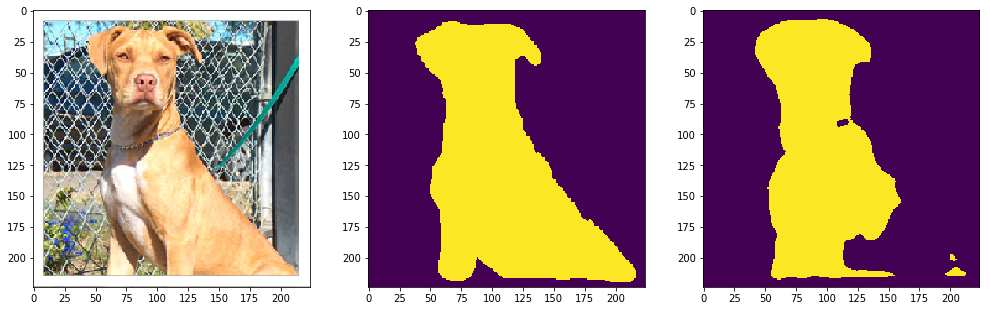

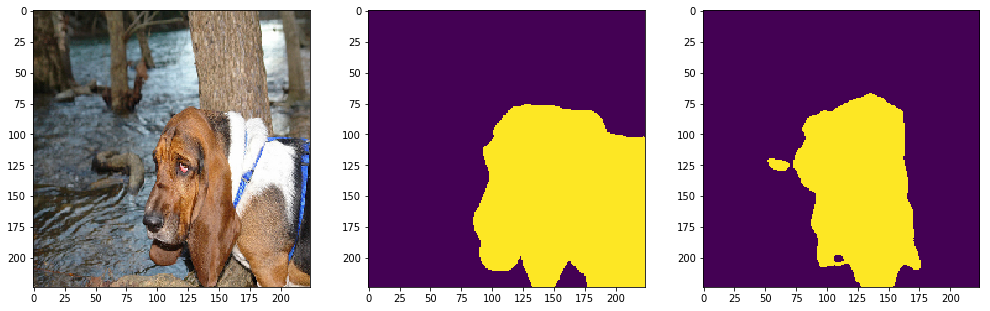

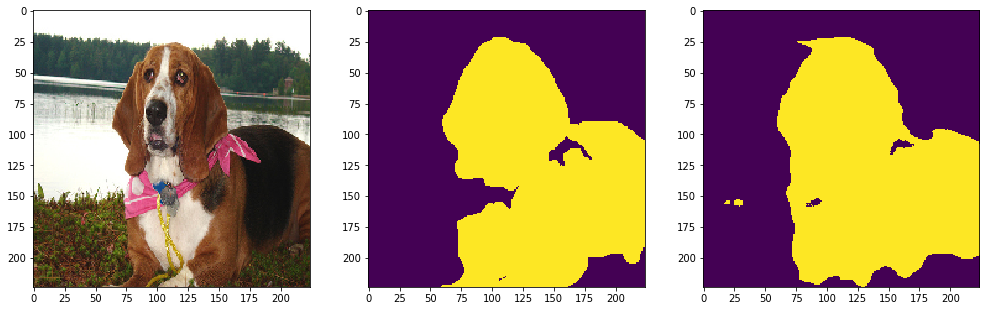

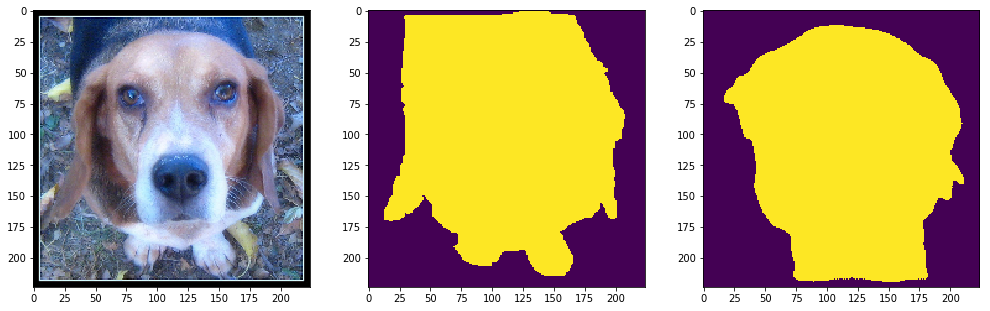

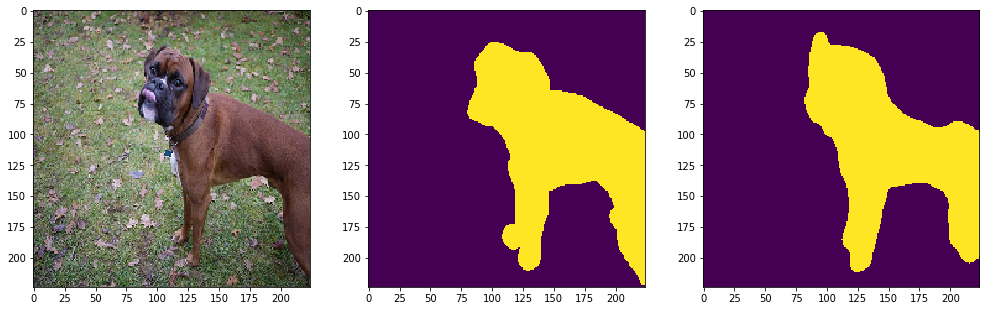

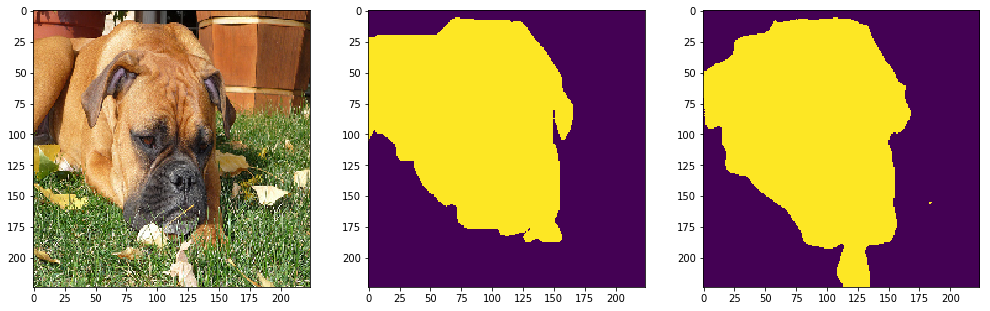

In [33]:
## num_imgs만큼 validation dataset에서 읽어서 정답과 예측값 확인
num_imgs = 10
idx = 0
for image, seg in val_dataset.take(num_imgs):
    plt.figure(figsize=(17, 6*num_imgs))
    plt.subplot(num_imgs,3,idx*3+1)
    plt.imshow(image[0])
    plt.subplot(num_imgs,3,idx*3+2)
    plt.imshow(seg[0,:,:,0], vmin=0, vmax=1)
    plt.subplot(num_imgs,3,idx*3+3)
    plt.imshow(pred[idx*batch_size,:,:,1])
    plt.show() 
    idx += 1

# Segmentation using pretrained VGG

In [0]:
from tensorflow.keras.utils import get_file

In [35]:
## vgg16 pretrained weights 다운로드
weight_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
def create_model():
    inputs = Input(shape=(img_size, img_size, 3))
    
    conv1_1 = Conv2D(64, 3, 1, 'SAME', activation='relu')(inputs)
    conv1_2 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)
    
    conv2_1 = Conv2D(128, 3, 1, 'SAME', activation='relu')(pool1_3)
    conv2_2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)
    
    conv3_1 = Conv2D(256, 3, 1, 'SAME', activation='relu')(pool2_3)
    conv3_2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)
    
    conv4_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool3_4)
    conv4_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)
    
    conv5_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool4_4)
    conv5_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_2)
    pool5_4 = MaxPooling2D()(conv5_3)
    
    ## loading vgg16 pretrained weights
    vgg = keras.Model(inputs, pool5_4)
    vgg.load_weights(weight_path)
    
    upconv6 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(pool5_4)
    concat6 = Concatenate()([conv5_3, upconv6])
    conv6 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat6)
                              
    upconv7 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(conv6)
    concat7 = Concatenate()([conv4_3, upconv7])
    conv7 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat7)
    
    upconv8 = Conv2DTranspose(256, 5, 2, 'SAME', activation='relu')(conv7)
    concat8 = Concatenate()([conv3_3, upconv8])
    conv8 = Conv2D(256, 3, 1, 'SAME', activation='relu')(concat8)
    
    upconv9 = Conv2DTranspose(128, 5, 2, 'SAME', activation='relu')(conv8)
    concat9 = Concatenate()([conv2_2, upconv9])
    conv9 = Conv2D(128, 3, 1, 'SAME', activation='relu')(concat9)
    
    upconv10 = Conv2DTranspose(64, 5, 2, 'SAME', activation='relu')(conv9)
    concat10 = Concatenate()([conv1_2, upconv10])
    conv10 = Conv2D(64, 3, 1, 'SAME', activation='relu')(concat10)
    
    conv11 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv10)
    
    conv12 = Conv2D(2, 1, 1, 'SAME', activation='softmax')(conv11)
    
    return keras.Model(inputs=inputs, outputs=conv12) 

In [37]:
model = create_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_53[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_54[0][0]                  
____________________________________________________________________________________________

In [0]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
model.compile(optimizers.Adam(lr_schedule), loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [0]:
## Train!
steps_per_epoch = n_train//batch_size
validation_steps = n_val//batch_size
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=training_epochs,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Train for 200 steps, validate for 49 steps
Epoch 1/20
200/200 [==============================] - 267s 1s/step - loss: 0.3102 - sparse_categorical_accuracy: 0.8610 - val_loss: 0.2134 - val_sparse_categorical_accuracy: 0.9144
Epoch 2/20
200/200 [==============================] - 264s 1s/step - loss: 0.1829 - sparse_categorical_accuracy: 0.9286 - val_loss: 0.1662 - val_sparse_categorical_accuracy: 0.9344
Epoch 3/20
200/200 [==============================] - 264s 1s/step - loss: 0.1622 - sparse_categorical_accuracy: 0.9362 - val_loss: 0.1514 - val_sparse_categorical_accuracy: 0.9403
Epoch 4/20
200/200 [==============================] - 263s 1s/step - loss: 0.1297 - sparse_categorical_accuracy: 0.9491 - val_loss: 0.1423 - val_sparse_categorical_accuracy: 0.9459
Epoch 5/20
200/200 [==============================] - 264s 1s/step - loss: 0.1098 - sparse_categorical_accuracy: 0.9569 - val_loss: 0.1387 - val_sparse_categorical_accuracy: 0.9491
Epoch 6/20
200/200 [==============================] 

In [0]:
## validation data에 대한 예측값 생성
prediction = model.predict(val_dataset, steps=validation_steps)

In [0]:
pred = np.zeros_like(prediction)

In [0]:
## 0.5이상은 1로 나머지는 0으로 변환
thr = 0.5
pred[prediction>=thr] = 1
pred[prediction<thr] = 0

In [0]:
## num_imgs만큼 validation dataset에서 읽어서 정답과 예측값 확인
num_imgs = 10
idx = 0
for image, seg in val_dataset.take(num_imgs):
    plt.figure(figsize=(17, 6*num_imgs))
    plt.subplot(num_imgs,3,idx*3+1)
    plt.imshow(image[0])
    plt.subplot(num_imgs,3,idx*3+2)
    plt.imshow(seg[0,:,:,0], vmin=0, vmax=1)
    plt.subplot(num_imgs,3,idx*3+3)
    plt.imshow(pred[idx*batch_size,:,:,1])
    plt.show() 
    idx += 1

# Colorization

In [0]:
## hyper parameter 설정
batch_size = 10
learning_rate = 0.0001
training_epochs = 20
img_size = 224
n_train = 2000
n_val = 498

In [0]:
## tfrecord file 경로 설정
cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'dogs_tfr')

tfr_train = 'dogs_seg_train.tfrecord'
tfr_val = 'dogs_seg_val.tfrecord'

tfr_train_dir = os.path.join(tfr_dir, tfr_train)
tfr_val_dir = os.path.join(tfr_dir, tfr_val)

In [0]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'seg': tf.io.FixedLenFeature([], tf.string),
              'grayimg': tf.io.FixedLenFeature([], tf.string)
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [img_size, img_size, 3])
    image = tf.cast(image, tf.float32)/255.
    #image = preprocess_input(image)
    
    seg = tf.io.decode_raw(parsed_features['seg'], tf.uint8)
    seg = tf.reshape(seg, [img_size, img_size, -1])
    seg = tf.cast(seg, tf.float32)
    
    grayimg = tf.io.decode_raw(parsed_features['grayimg'], tf.float64)    
    grayimg = tf.reshape(grayimg, [img_size, img_size])
    grayimg = tf.stack([grayimg, grayimg, grayimg], -1)
    grayimg = tf.cast(grayimg, tf.float32)/255.
    print(grayimg.shape)
    
    #return image, seg
    return grayimg, image

In [0]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=8)
train_dataset = train_dataset.prefetch(buffer_size=batch_size).batch(batch_size).shuffle(n_train).repeat()
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())

In [0]:
## validation datset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=8)
val_dataset = val_dataset.prefetch(buffer_size=batch_size).batch(batch_size).repeat()
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())

In [0]:
## train dataset에서 1개의 grayscale image와 원본 image를 읽어서 확인
for grayimg, image in val_dataset.take(1):
    plt.figure(figsize=(11, 5))
    plt.subplot(1,2,1)
    plt.imshow(grayimg[0])
    plt.subplot(1,2,2)    
    plt.imshow(image[0]) 
    plt.show()

In [0]:
def create_model():
    inputs = Input(shape=(img_size, img_size, 3))
    
    conv1_1 = Conv2D(64, 3, 1, 'SAME', activation='relu')(inputs)
    conv1_2 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)
    
    conv2_1 = Conv2D(128, 3, 1, 'SAME', activation='relu')(pool1_3)
    conv2_2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)
    
    conv3_1 = Conv2D(256, 3, 1, 'SAME', activation='relu')(pool2_3)
    conv3_2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)
    
    conv4_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool3_4)
    conv4_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)
    
    conv5_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool4_4)
    conv5_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_2)
    pool5_4 = MaxPooling2D()(conv5_3)
    
    upconv6 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(pool5_4)
    concat6 = Concatenate()([conv5_3, upconv6])
    conv6 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat6)
                              
    upconv7 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(conv6)
    concat7 = Concatenate()([conv4_3, upconv7])
    conv7 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat7)
    
    upconv8 = Conv2DTranspose(256, 5, 2, 'SAME', activation='relu')(conv7)
    concat8 = Concatenate()([conv3_3, upconv8])
    conv8 = Conv2D(256, 3, 1, 'SAME', activation='relu')(concat8)
    
    upconv9 = Conv2DTranspose(128, 5, 2, 'SAME', activation='relu')(conv8)
    concat9 = Concatenate()([conv2_2, upconv9])
    conv9 = Conv2D(128, 3, 1, 'SAME', activation='relu')(concat9)
    
    upconv10 = Conv2DTranspose(64, 5, 2, 'SAME', activation='relu')(conv9)
    concat10 = Concatenate()([conv1_2, upconv10])
    conv10 = Conv2D(64, 3, 1, 'SAME', activation='relu')(concat10)
    
    conv11 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv10)
    
    conv12 = Conv2D(3, 1, 1, 'SAME', activation='sigmoid')(conv11)
    
    return keras.Model(inputs=inputs, outputs=conv12)

In [0]:
model = create_model()
model.summary()

In [0]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(optimizers.RMSprop(lr_schedule), loss='mse')

In [0]:
## Train!
steps_per_epoch = n_train//batch_size
validation_steps = n_val//batch_size
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=training_epochs,
         validation_data=val_dataset,
         validation_steps=validation_steps)

In [0]:
prediction = model.predict(val_dataset, steps=validation_steps)

In [0]:
## 결과 확인
num_imgs = 10
idx = 0
for grayimg, image in val_dataset.take(num_imgs):
    plt.figure(figsize=(17, 6*num_imgs))
    plt.subplot(num_imgs,3,idx*3+1)
    plt.imshow(grayimg[0], cmap='gray')
    plt.subplot(num_imgs,3,idx*3+2)
    plt.imshow(image[0], vmin=0, vmax=1)
    plt.subplot(num_imgs,3,idx*3+3)
    plt.imshow(prediction[idx*batch_size])
    plt.show() 
    idx += 1

# Colorization using pretrained VGG

In [0]:
## hyper parameter 설정
batch_size = 10
learning_rate = 0.0001
training_epochs = 20
img_size = 224
n_train = 2000
n_val = 498

In [0]:
## vgg16 pretrained weights 다운로드
weight_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [0]:
def create_model():
    inputs = Input(shape=(img_size, img_size, 3))
    
    conv1_1 = Conv2D(64, 3, 1, 'SAME', activation='relu')(inputs)
    conv1_2 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)
    
    conv2_1 = Conv2D(128, 3, 1, 'SAME', activation='relu')(pool1_3)
    conv2_2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)
    
    conv3_1 = Conv2D(256, 3, 1, 'SAME', activation='relu')(pool2_3)
    conv3_2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)
    
    conv4_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool3_4)
    conv4_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)
    
    conv5_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool4_4)
    conv5_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_2)
    pool5_4 = MaxPooling2D()(conv5_3)
    
    vgg = keras.Model(inputs, pool5_4)
    vgg.load_weights(weight_path)
    
    upconv6 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(pool5_4)
    concat6 = Concatenate()([conv5_3, upconv6])
    conv6 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat6)
                              
    upconv7 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(conv6)
    concat7 = Concatenate()([conv4_3, upconv7])
    conv7 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat7)
    
    upconv8 = Conv2DTranspose(256, 5, 2, 'SAME', activation='relu')(conv7)
    concat8 = Concatenate()([conv3_3, upconv8])
    conv8 = Conv2D(256, 3, 1, 'SAME', activation='relu')(concat8)
    
    upconv9 = Conv2DTranspose(128, 5, 2, 'SAME', activation='relu')(conv8)
    concat9 = Concatenate()([conv2_2, upconv9])
    conv9 = Conv2D(128, 3, 1, 'SAME', activation='relu')(concat9)
    
    upconv10 = Conv2DTranspose(64, 5, 2, 'SAME', activation='relu')(conv9)
    concat10 = Concatenate()([conv1_2, upconv10])
    conv10 = Conv2D(64, 3, 1, 'SAME', activation='relu')(concat10)
    
    conv11 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv10)
    
    conv12 = Conv2D(3, 1, 1, 'SAME', activation='sigmoid')(conv11)
    
    return keras.Model(inputs=inputs, outputs=conv12)

In [0]:
model = create_model()
model.summary()

In [0]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 RMSprop, loss는 mean squared error 사용
model.compile(optimizers.RMSprop(lr_schedule), loss='mse')

In [0]:
## Train!
steps_per_epoch = n_train//batch_size
validation_steps = n_val//batch_size
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=training_epochs,
         validation_data=val_dataset,
         validation_steps=validation_steps)

In [0]:
prediction = model.predict(val_dataset, steps=validation_steps)

In [0]:
## 결과확인
num_imgs = 10
idx = 0
for grayimg, image in val_dataset.take(num_imgs):
    plt.figure(figsize=(17, 6*num_imgs))
    plt.subplot(num_imgs,3,idx*3+1)
    plt.imshow(grayimg[0], cmap='gray')
    plt.subplot(num_imgs,3,idx*3+2)
    plt.imshow(image[0], vmin=0, vmax=1)
    plt.subplot(num_imgs,3,idx*3+3)
    plt.imshow(prediction[idx*batch_size])
    plt.show() 
    idx += 1